In [3]:
import sys
print(sys.executable)

/home/tomislav/mambaforge-pypy3/envs/houses_tf/bin/python


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_decision_forests as tfdf

import mlflow


2023-09-13 10:24:11.898570: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 10:24:11.946860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-13 10:24:11.947806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 10:24:12.828923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
mlflow.set_tracking_uri("sqlite:///../mlflow.db")
mlflow.set_experiment("houses")

<Experiment: artifact_location='/media/tomislav/023ABC973ABC8965/Projekti/MLOps-Testing/src/mlruns/1', creation_time=1694531835222, experiment_id='1', last_update_time=1694531835222, lifecycle_stage='active', name='houses', tags={}>

In [4]:
dataset_path = "../data/house-prices-advanced-regression-techniques/"
tr_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))

tr_df.loc[tr_df["MasVnrArea"].isnull() & tr_df["MasVnrType"].isnull(), "MasVnrArea"] = 0.0
tr_df.dropna(subset=["Electrical"], inplace=True)
tr_df.drop(tr_df[tr_df["BsmtFinType1"].notnull() & tr_df["BsmtFinType2"].isnull()].index[0], inplace=True)
tr_df.loc[tr_df["LotFrontage"].isnull(), "LotFrontage"] = tr_df["LotFrontage"].mean()
tr_df.drop(columns="Id", inplace=True)
tr_df.drop(columns=["Alley", "PoolQC", "Fence", "MiscFeature", "FireplaceQu", "Fireplaces"], axis=1, inplace=True)

test_ids = test_df.pop('Id')

print(tr_df.shape)
print(test_df.shape)


(1458, 74)
(1459, 79)


In [27]:
nullseries = tr_df.isnull().sum()
print(nullseries[nullseries > 0])

MasVnrType      871
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     37
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


In [5]:
print(len(tr_df))
val_ratio = 0.2
interval = len(tr_df) * val_ratio
interval = np.floor(interval).astype(np.int16)
print(interval)
print(interval*5)

splits = []
pool = np.array(range(len(tr_df)))
for i in range(int(1/val_ratio)):
    split = np.random.choice(pool, size=interval, replace=False)
    split = split.tolist()
    splits.append(split)
    print(i)
    pool = pool[np.isin(pool, split, invert=True)]
for i in range(len(splits)):
    print(len(splits[i]))

1458
291
1455
0
1
2
3
4
291
291
291
291
291


In [28]:
import tensorflow.keras.backend as K

def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred))

In [79]:

best_loss = 9999

for i in range(len(splits)):
    val_pool = splits[i]
    train_pool = []
    for j in range(len(splits)):
        if i == j:
            continue
        train_pool.append(splits[j])
    train_pool = np.hstack(train_pool).tolist()
    train_data = tr_df.iloc(axis=0)[train_pool]
    val_data = tr_df.iloc(axis=0)[val_pool]
    #print(val_pool)
    #print("val " + str(len(val_data)))
    #print(train_pool.shape)
    #print(train_pool.shape[0] + len(val_data))
    #print("train " + str(len(train_pool)) + " " + str(len(train_pool[0])))

    label = "SalePrice"
    train_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=label, task = tfdf.keras.Task.REGRESSION)
    val_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        val_data, label=label, task = tfdf.keras.Task.REGRESSION)

    
    #model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",
    #                                    task=tfdf.keras.Task.REGRESSION)
    
    model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    model.compile(
        loss = [tf.keras.losses.MeanSquaredLogarithmicError()],
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    model.fit(x=train_data, verbose=0)

    #inspector = model.make_inspector()
    #inspector.evaluation()

    eval = model.evaluate(x=val_data, return_dict=True)
    #for name, value in eval.items():
    #    print(f"{name}: {value:.4f}")

    model_loss = eval["loss"]
    if model_loss < best_loss:
        best_loss = model_loss
        best_model = tf.keras.models.clone_model(model)


    

        
            


[INFO 23-09-12 11:06:06.9531 CEST kernel.cc:1243] Loading model from path /tmp/tmp32dhqnk_/model/ with prefix 86e3a33d2996408d
[INFO 23-09-12 11:06:07.2664 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110542 node(s), and 73 input feature(s).
[INFO 23-09-12 11:06:07.2664 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-12 11:06:07.2664 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 285ms/step - loss: 0.0236 - rmse: 35965.8398


[INFO 23-09-12 11:06:10.4976 CEST kernel.cc:1243] Loading model from path /tmp/tmpbkq9cvb6/model/ with prefix 600d8b2a951b4d73
[INFO 23-09-12 11:06:10.7769 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110500 node(s), and 73 input feature(s).
[INFO 23-09-12 11:06:10.7770 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 288ms/step - loss: 0.0155 - rmse: 30337.1816


[INFO 23-09-12 11:06:14.0603 CEST kernel.cc:1243] Loading model from path /tmp/tmp68u5ak7e/model/ with prefix 44f5f582bad54b5c
[INFO 23-09-12 11:06:14.3393 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110334 node(s), and 74 input feature(s).
[INFO 23-09-12 11:06:14.3393 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 268ms/step - loss: 0.0176 - rmse: 22216.2266


[INFO 23-09-12 11:06:17.6421 CEST kernel.cc:1243] Loading model from path /tmp/tmph06cecdt/model/ with prefix ddaa5f3829dd48e0
[INFO 23-09-12 11:06:17.9145 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110530 node(s), and 76 input feature(s).
[INFO 23-09-12 11:06:17.9146 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-12 11:06:17.9146 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 267ms/step - loss: 0.0198 - rmse: 26366.2070


[INFO 23-09-12 11:06:21.0048 CEST kernel.cc:1243] Loading model from path /tmp/tmp4y9695il/model/ with prefix 76f2042ffce94fb3
[INFO 23-09-12 11:06:21.2768 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110406 node(s), and 75 input feature(s).
[INFO 23-09-12 11:06:21.2769 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 278ms/step - loss: 0.0217 - rmse: 27893.2031


In [18]:
mlflow.tensorflow.autolog(disable=True)
with mlflow.start_run(run_name='rf_baseline'):
    params = {
        'bootstrap_training_dataset': False,
        'bootstrap_size_ratio': 0.7,
        'max_depth': 20,
        'num_trees': 350,
    }

    mlflow.set_tag("model_name", "RF")
    mlflow.log_params(params=params)

    i=1 
    val_pool = splits[i]
    train_pool = []
    for j in range(len(splits)):
        if i == j:
            continue
        train_pool.append(splits[j])
    train_pool = np.hstack(train_pool).tolist()
    train_data = tr_df.iloc(axis=0)[train_pool]
    val_data = tr_df.iloc(axis=0)[val_pool]

    label = "SalePrice"
    train_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=label, task = tfdf.keras.Task.REGRESSION)
    val_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        val_data, label=label, task = tfdf.keras.Task.REGRESSION)


    #model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",
    #                                    task=tfdf.keras.Task.REGRESSION)

    model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0,
                bootstrap_training_dataset=params['bootstrap_training_dataset'],
                bootstrap_size_ratio=params['bootstrap_size_ratio'],
                max_depth=params['max_depth'],
                num_trees=params['num_trees'])

    model.compile(
        loss = [tf.keras.losses.MeanSquaredLogarithmicError()],
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    params = model.learner_params
    import pprint
    pprint.pprint(pprint.pformat(params, depth=1))
    #print(params)

    model.fit(x=train_data, verbose=0)


    eval = model.evaluate(x=val_data, return_dict=True)
    #for name, value in eval.items():
    #    print(f"{name}: {value:.4f}")

    mlflow.log_metric("val_rmse", eval['rmse'])
    mlflow.log_metric("val_msle", eval["loss"])
    mlflow.log_metric("val_rmsle", np.sqrt(eval["loss"]))


("DictWrapper({'adapt_bootstrap_size_ratio_for_maximum_training_duration': "
 "False, 'allow_na_conditions': False, 'bootstrap_size_ratio': 0.7, "
 "'bootstrap_training_dataset': False, 'categorical_algorithm': 'CART', "
 "'categorical_set_split_greedy_sampling': 0.1, "
 "'categorical_set_split_max_num_items': -1, "
 "'categorical_set_split_min_item_frequency': 1, 'compute_oob_performances': "
 "True, 'compute_oob_variable_importances': False, 'growing_strategy': "
 "'LOCAL', 'honest': False, 'honest_fixed_separation': False, "
 "'honest_ratio_leaf_examples': 0.5, 'in_split_min_examples_check': True, "
 "'keep_non_leaf_label_distribution': True, 'max_depth': 20, 'max_num_nodes': "
 "None, 'maximum_model_size_in_memory_in_bytes': -1.0, "
 "'maximum_training_duration_seconds': -1.0, 'min_examples': 5, "
 "'missing_value_policy': 'GLOBAL_IMPUTATION', 'num_candidate_attributes': 0, "
 "'num_candidate_attributes_ratio': -1.0, "
 "'num_oob_variable_importances_permutations': 1, 'num_trees': 

[INFO 23-09-12 17:19:06.3872 CEST kernel.cc:1243] Loading model from path /tmp/tmp7k1frtx3/model/ with prefix 290e4e7eda3240d6
[INFO 23-09-12 17:19:06.7274 CEST decision_forest.cc:660] Model loaded with 350 root(s), 130442 node(s), and 70 input feature(s).
[INFO 23-09-12 17:19:06.7275 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 290ms/step - loss: 0.0201 - rmse: 25247.0996


In [24]:
from mlflow.data.pandas_dataset import PandasDataset

mlflow.tensorflow.autolog(disable=True)
with mlflow.start_run(run_name='grad_boost_top'):

    mlflow.set_tag("model_name", "Grad_boost")

    i=1 
    val_pool = splits[i]
    train_pool = []
    for j in range(len(splits)):
        if i == j:
            continue
        train_pool.append(splits[j])
    train_pool = np.hstack(train_pool).tolist()
    train_data = tr_df.iloc(axis=0)[train_pool]
    val_data = tr_df.iloc(axis=0)[val_pool]

    mlflow_train_dataset: PandasDataset = mlflow.data.from_pandas(train_data)
    mlflow_val_dataset: PandasDataset = mlflow.data.from_pandas(val_data)

    mlflow.log_input(mlflow_train_dataset)
    mlflow.log_input(mlflow_val_dataset)


    label = "SalePrice"
    train_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=label, task = tfdf.keras.Task.REGRESSION)
    val_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        val_data, label=label, task = tfdf.keras.Task.REGRESSION)
    
    #model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
    #model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
    model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",
        task=tfdf.keras.Task.REGRESSION)

    #model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",
    #                                    task=tfdf.keras.Task.REGRESSION)

    #model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0,
    #            bootstrap_training_dataset=params['bootstrap_training_dataset'],
    #            bootstrap_size_ratio=params['bootstrap_size_ratio'],
    #            max_depth=params['max_depth'],
    #            num_trees=params['num_trees'])

    model.compile(
        loss = [tf.keras.losses.MeanSquaredLogarithmicError()],
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    all_params = model.learner_params
    #params = {
    #    'bootstrap_training_dataset': all_params['bootstrap_training_dataset'],
    #    'bootstrap_size_ratio': all_params['bootstrap_size_ratio'],
    #    'max_depth': all_params['max_depth'],
    #    'num_trees': all_params['num_trees'],
    #}
    param = all_params
    mlflow.log_params(params=all_params)
    import pprint
    #pprint.pprint(pprint.pformat(all_params, depth=1))
    #print(params)

    model.fit(x=train_data, verbose=0)


    eval = model.evaluate(x=val_data, return_dict=True)
    #for name, value in eval.items():
    #    print(f"{name}: {value:.4f}")

    mlflow.log_metric("val_rmse", eval['rmse'])
    mlflow.log_metric("val_msle", eval["loss"])
    mlflow.log_metric("val_rmsle", np.sqrt(eval["loss"]))
    input_example = tr_df.iloc[[0]]

    mlflow.tensorflow.log_model(model, "tf_models", input_example=input_example)

/home/tomislav/mambaforge-pypy3/envs/houses_tf/lib/python3.11/site-packages/mlflow/data/digest_utils.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/home/tomislav/mambaforge-pypy3/envs/houses_tf/lib/python3.11/site-packages/mlflow/data/digest_utils.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
2023/09/13 12:26:42 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/09/13 12:26:42 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values h

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpi3qefnt0 as temporary training directory


[WARNING 23-09-13 12:26:42.5148 CEST gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-13 12:26:42.5148 CEST gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-09-13 12:26:42.5148 CEST gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-09-13 12:26:46.7156 CEST kernel.cc:1243] Loading model from path /tmp/tmpi3qefnt0/model/ with prefix 1391067cc99f4e15
[INFO 23-09-13 12:26:46.7332 CEST decision_forest.cc:660] Model loaded with 108 root(s), 4872 node(s), and 68 input feature(s).
[INFO 23-09-13 12:26:46.7332 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-09-13 12:26:46.7333 CEST kernel.cc:1075] Use fast generic engine


1/1 [==============================] - 0s 256ms/step - loss: 0.0203 - rmse: 31228.8027


/home/tomislav/mambaforge-pypy3/envs/houses_tf/lib/python3.11/site-packages/mlflow/models/signature.py:335: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  input_schema = _infer_schema(input_ex)
2023/09/13 12:26:48 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: ValueError('Failed to convert a NumPy array to a Tensor (Unsup

INFO:tensorflow:Assets written to: /tmp/tmpmza7b9s7/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpmza7b9s7/model/data/model/assets
2023/09/13 12:26:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpmza7b9s7/model, flavor: tensorflow), fall back to return ['tensorflow==2.13.0']. Set logging level to DEBUG to see the full traceback.


In [8]:
for item in train_data:
    print(item[0])
    break

{'MSSubClass': <tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([ 60,  50,  60,  60,  20,  80,  20,  20,  30,  20,  20,  20,  80,
        20,  20,  90,  20,  80,  20,  60,  30,  20, 160,  60,  20,  90,
        20,  20, 190,  20,  20,  20,  20,  60,  70,  50,  30, 180,  60,
        30, 160,  20, 120,  50,  20,  20,  50,  20,  20,  20,  90,  50,
        20,  85,  50, 160,  20, 120,  60,  20,  20,  60,  20,  60,  60,
       160,  70,  20,  60,  60,  50,  50, 160,  60, 120,  90,  60,  20,
        30,  60, 180, 160,  50,  60,  90,  20,  60,  20,  20, 120,  60,
       120,  60,  20,  60,  70,  60,  75,  20,  60,  20, 190,  60,  20,
        20,  20,  60,  20,  80,  90,  60,  60,  30,  90,  80,  60,  30,
        60,  50,  20,  60,  50,  60, 120,  60,  50,  60, 120,  20, 120,
        60,  40,  60,  60,  90,  20,  45,  75,  60,  20,  70,  75,  90,
        50,  20,  60,  50,  30,  20,  60, 190,  60,  20,  80,  50,  50,
        20,  50,  20, 120,  60,  20,  20,  60,  60,  80,  60,  50,  20,
  

In [32]:
tr_df.iloc[[0]]
#tr_df[~tr_df.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500


In [125]:
params = {
    'bootstrap_training_dataset': True,
    'bootstrap_size_ratio': 1.0,
    'max_depth': 16,
    'max_num_nodes': None,
    'num_trees': 300,
}

In [27]:
#best_model = tf.keras.models.load_model("../saved_models/houses_best", 
#                custom_objects={'loss': root_mean_squared_log_error}, compile=True)
#loaded_model.compile(
#        loss=[root_mean_squared_log_error],
#        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

model.summary()
eval = model.evaluate(x=val_data, return_dict=True)

for name, value in eval.items():
        print(f"{name}: {value:.4f}")

test_data = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_df, task = tfdf.keras.Task.REGRESSION)

preds = model.predict(x=test_data)
output = pd.DataFrame({'Id':test_ids, 
                       'SalePrice':preds.squeeze()})

output.head()

submission_df = pd.read_csv("../data/house-prices-advanced-regression-techniques/sample_submission.csv")
submission_df["SalePrice"] = model.predict(test_data)
submission_df.to_csv("../kaggle/working/submission.csv", index=False)
submission_df.head()

Model: "gradient_boosted_trees_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (73):
	1stFlrSF
	2ndFlrSF
	3SsnPorch
	BedroomAbvGr
	BldgType
	BsmtCond
	BsmtExposure
	BsmtFinSF1
	BsmtFinSF2
	BsmtFinType1
	BsmtFinType2
	BsmtFullBath
	BsmtHalfBath
	BsmtQual
	BsmtUnfSF
	CentralAir
	Condition1
	Condition2
	Electrical
	EnclosedPorch
	ExterCond
	ExterQual
	Exterior1st
	Exterior2nd
	Foundation
	FullBath
	Functional
	GarageArea
	GarageCars
	GarageCond
	GarageFinish
	GarageQual
	GarageType
	GarageYrBlt
	GrLivArea
	HalfBath
	Heating
	HeatingQC
	HouseStyle
	KitchenAbvGr
	KitchenQual
	LandContour
	LandSlope
	LotArea
	LotConfig
	LotFrontage
	LotShape
	LowQualFinSF
	MSSub

,Id,SalePrice
0,1461,124908.804688
1,1462,163912.000000
2,1463,181143.984375
3,1464,183563.453125
4,1465,189247.625000


In [26]:
submission_df.head()
print(submission_df.shape)

(1459, 2)


In [7]:
model.summary()

Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (79):
	1stFlrSF
	2ndFlrSF
	3SsnPorch
	Alley
	BedroomAbvGr
	BldgType
	BsmtCond
	BsmtExposure
	BsmtFinSF1
	BsmtFinSF2
	BsmtFinType1
	BsmtFinType2
	BsmtFullBath
	BsmtHalfBath
	BsmtQual
	BsmtUnfSF
	CentralAir
	Condition1
	Condition2
	Electrical
	EnclosedPorch
	ExterCond
	ExterQual
	Exterior1st
	Exterior2nd
	Fence
	FireplaceQu
	Fireplaces
	Foundation
	FullBath
	Functional
	GarageArea
	GarageCars
	GarageCond
	GarageFinish
	GarageQual
	GarageType
	GarageYrBlt
	GrLivArea
	HalfBath
	Heating
	HeatingQC
	HouseStyle
	KitchenAbvGr
	KitchenQual
	LandContour
	LandSlope
	LotArea
	LotConfig
	LotFrontage
	LotShape

In [55]:
model_params = model.learner_params
print(model_params)
param1 = model_params["honest_ratio_leaf_examples"]

AttributeError: 'RandomForestModel' object has no attribute 'learner_params'

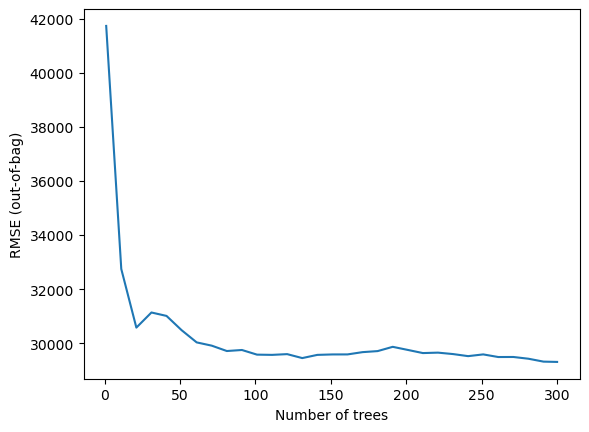

Evaluation(num_examples=1164, accuracy=None, loss=None, rmse=29307.852699248662, ndcg=None, aucs=None, auuc=None, qini=None)

In [8]:
logs = model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

inspector = model.make_inspector()
inspector.evaluation()

In [89]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [19]:
nullseries = tr_df.isnull().sum()
print(nullseries[nullseries > 0])

Alley           1367
MasVnrType       871
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      37
FireplaceQu      689
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1177
MiscFeature     1404
dtype: int64


In [39]:
logged_model = 'runs:/99fe0a6434bf451fbc886c1d56e054d2/tf_models'
loaded_ft = mlflow.tensorflow.load_model(logged_model)
loaded_ft.summary()

eval = loaded_ft.evaluate(x=val_data, return_dict=True)

[INFO 23-09-13 10:13:16.3103 CEST kernel.cc:1243] Loading model from path /media/tomislav/023ABC973ABC8965/Projekti/MLOps-Testing/src/mlruns/1/99fe0a6434bf451fbc886c1d56e054d2/artifacts/tf_models/data/model/assets/ with prefix c6765bf1fb3b401e
[INFO 23-09-13 10:13:16.6309 CEST decision_forest.cc:660] Model loaded with 300 root(s), 110520 node(s), and 70 input feature(s).
[INFO 23-09-13 10:13:16.6309 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-13 10:13:16.6310 CEST kernel.cc:1075] Use fast generic engine


Model: "random_forest_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 288ms/step - loss: 0.0249 - rmse: 29039.8066
